In [1]:
import plotly
import plotly.graph_objs as go
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from collections import Counter

from scipy.special import expit

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score, GridSearchCV
from sklearn import tree

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from optbinning import BinningProcess, OptimalBinning # Para cáclulos WOE e IV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2, l1

from tabulate import tabulate

import statsmodels.api as sm
import statsmodels.formula.api as smf

2025-06-28 12:39:14.326201: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model


In [63]:
data = pd.read_csv('vacuum_sensor_data.csv', sep = ';')
data

,momento,1-0005,5-0005,1-_006,5-_006,1-_007,5-_007,1-_008,5-_008,1-_010,...,1-_098,5-_098,1-_099,5-_099,1-0112,5-0112,1-0116,5-0116,1-0109,5-0109
0,1,-588.88,-580.21,-590.50,-582.25,-593.51,-585.46,-595.51,-587.47,-575.36,...,-588.17,-581.42,-594.26,-586.26,-589.46,-581.75,-592.92,-586.26,-593.93,-586.30
1,2,-588.38,-579.71,-590.80,-582.46,-593.80,-585.67,-595.55,-587.59,-574.11,...,-588.34,-581.63,-594.51,-586.26,-589.29,-581.58,-592.80,-586.26,-594.13,-586.51
2,3,-584.41,-575.74,-585.83,-577.66,-591.38,-583.21,-589.84,-578.04,-563.34,...,-588.17,-581.33,-592.88,-584.34,-588.50,-580.62,-590.21,-583.75,-593.68,-585.84
3,4,-573.73,-565.27,-570.31,-562.81,-578.91,-571.24,-578.61,-565.90,-555.00,...,-584.79,-576.87,-580.62,-568.15,-586.96,-578.75,-578.66,-571.19,-590.88,-582.63
4,5,-567.27,-558.55,-562.26,-554.55,-570.69,-562.93,-567.18,-557.51,-545.99,...,-579.11,-570.99,-572.11,-560.43,-583.45,-574.91,-571.06,-563.56,-587.38,-578.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,637,-237.18,-253.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,638,-237.10,-253.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,639,-237.14,-253.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,640,-237.10,-253.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
#rename column to have consistent naming 
import re

def clean_column(col):
    if col == 'momento':
        return col
    match = re.match(r"(\d)-_?(\d+)", col)
    if match:
        sensor, comp = match.groups()
        return f"{sensor}-{int(comp):04d}"
    return col  # fallback in case format is already correct

# Apply renaming
data.columns = [clean_column(col) for col in data.columns]

In [65]:
# drop rows(seconds) where data from any sensor is missing
data=data.dropna(axis=0)

In [67]:
data.shape

(151, 77)

In [66]:
# narrow the time window
data=data.iloc[49:200] 


In [68]:
#split columns into train and validation
defective_columns = ['1-0116', '5-0116', '1-0109', '5-0109']
normal_control_columns = ['1-0008', '5-0008', '1-0064', '5-0064']
validation_columns = defective_columns + normal_control_columns

df_validation = data[['momento'] + validation_columns]
train_columns = [col for col in data.columns if col not in validation_columns]
df_train = data[train_columns]


In [69]:
def create_sliding_windows(data, window_size, step_size=1):
    """
    Create sliding windows from time series data
    
    Args:
        data: DataFrame with time series data
        window_size: Size of each window
        step_size: Step size for sliding window
    
    Returns:
        3D array of shape (n_windows, window_size, n_features)
    """
    n_samples = len(data)
    n_windows = (n_samples - window_size) // step_size + 1
    n_features = data.shape[1]
    
    windows = np.zeros((n_windows, window_size, n_features))
    
    for i in range(n_windows):
        start_idx = i * step_size
        end_idx = start_idx + window_size
        windows[i] = data.iloc[start_idx:end_idx].values
    
    return windows


In [72]:
def prepare_component_data(df_train, df_validation, window_size=10, step_size=5):
    """
    Prepare training and validation data for LSTM Autoencoder
    
    Args:
        df_train: Training dataframe with momento and sensor columns
        df_validation: Validation dataframe with momento and sensor columns
        window_size: Size of sliding window
        step_size: Step size for sliding window
    
    Returns:
        X_train, X_val, component_labels, scaler
    """
    
    # Remove momento column for processing
    train_data = df_train.drop('momento', axis=1)
    val_data = df_validation.drop('momento', axis=1)
    
    # Get component names (extract unique component IDs)
    train_components = list(set([col.split('-')[1] for col in train_data.columns]))
    val_components = list(set([col.split('-')[1] for col in val_data.columns]))
    
    print(f"Training components: {len(train_components)}")
    print(f"Validation components: {len(val_components)}")
    
    # Prepare training data
    X_train_list = []
    
    for component in train_components:
        # Get sensor 1 and sensor 5 data for this component
        sensor1_col = f'1-{component}'
        sensor5_col = f'5-{component}'
        
        if sensor1_col in train_data.columns and sensor5_col in train_data.columns:
            component_data = train_data[[sensor1_col, sensor5_col]]
            
            # Create sliding windows for this component
            windows = create_sliding_windows(component_data, window_size, step_size)
            X_train_list.append(windows)
    
    # Combine all training windows
    X_train = np.vstack(X_train_list)
    
    # Prepare validation data
    X_val_list = []
    component_labels = []
    
    # Define which components are defective
    defective_components = ['0116', '0109']
    
    for component in val_components:
        sensor1_col = f'1-{component}'
        sensor5_col = f'5-{component}'
        
        if sensor1_col in val_data.columns and sensor5_col in val_data.columns:
            component_data = val_data[[sensor1_col, sensor5_col]]
            
            # Create sliding windows for this component
            windows = create_sliding_windows(component_data, window_size, step_size)
            X_val_list.append(windows)
            
            # Label: 1 for defective, 0 for normal
            is_defective = 1 if component in defective_components else 0
            component_labels.extend([is_defective] * len(windows))
    
    X_val = np.vstack(X_val_list)
    component_labels = np.array(component_labels)
# Normalize the data
    scaler = StandardScaler()
    
    # Reshape for scaling (combine all windows and time steps)
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_train_scaled = X_train_scaled.reshape(X_train.shape)
    
    X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
    X_val_scaled = scaler.transform(X_val_reshaped)
    X_val_scaled = X_val_scaled.reshape(X_val.shape)
    
    return X_train_scaled, X_val_scaled, component_labels, scaler


In [73]:
def build_lstm_autoencoder(window_size, n_features, encoding_dim=128):
    """
    Build LSTM Autoencoder model
    
    Args:
        window_size: Length of input sequences
        n_features: Number of features (should be 2 for sensor 1 and 5)
        encoding_dim: Dimension of the encoding layer
    
    Returns:
        Compiled Keras model
    """
    
    # Input layer
    input_layer = Input(shape=(window_size, n_features))
    
    # Encoder
    encoded = LSTM(encoding_dim, activation='relu')(input_layer)
    
    # Decoder
    decoded = RepeatVector(window_size)(encoded)
    decoded = LSTM(encoding_dim, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(n_features))(decoded)
    
    # Create and compile model
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return autoencoder


In [74]:
def calculate_reconstruction_error(model, X_data):
    """
    Calculate reconstruction error for each sample
    
    Args:
        model: Trained autoencoder model
        X_data: Input data
    
    Returns:
        Array of reconstruction errors
    """
    reconstructed = model.predict(X_data, verbose=0)
    mse = np.mean(np.square(X_data - reconstructed), axis=(1, 2))
    return mse


In [75]:
def plot_results(reconstruction_errors, labels, threshold):
    """
    Plot reconstruction errors and results
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot reconstruction errors
    normal_errors = reconstruction_errors[labels == 0]
    defective_errors = reconstruction_errors[labels == 1]
    
    ax1.hist(normal_errors, bins=20, alpha=0.7, label='Normal', color='blue')
    ax1.hist(defective_errors, bins=20, alpha=0.7, label='Defective', color='red')
    ax1.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.4f}')
    ax1.set_xlabel('Reconstruction Error')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Reconstruction Errors')
    ax1.legend()
    
    # Plot individual points
    ax2.scatter(range(len(normal_errors)), normal_errors, color='blue', label='Normal', alpha=0.7)
    ax2.scatter(range(len(normal_errors), len(reconstruction_errors)), defective_errors, 
                color='red', label='Defective', alpha=0.7)
    ax2.axhline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.4f}')
    ax2.set_xlabel('Sample Index')
    ax2.set_ylabel('Reconstruction Error')
    ax2.set_title('Reconstruction Errors by Sample')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


In [76]:
# Main execution function
def run_anomaly_detection(df_train, df_validation, window_size=10, step_size=5, 
                         encoding_dim=128, epochs=100, batch_size=32):
    """
    Run the complete anomaly detection pipeline
    
    Args:
        df_train: Training dataframe with momento and sensor columns
        df_validation: Validation dataframe with momento and sensor columns
        window_size: Size of sliding window (default: 30)
        step_size: Step size for sliding window (default: 10) 
        encoding_dim: LSTM encoding dimension (default: 32)
        epochs: Training epochs (default: 100)
        batch_size: Training batch size (default: 32)
    
    Returns:
        model, scaler, threshold, results_dict
    """
    
    print("=" * 50)
    print("LSTM AUTOENCODER ANOMALY DETECTION")
    print("=" * 50)
    
    print("Preparing data...")
    # Prepare the data
    X_train, X_val, val_labels, scaler = prepare_component_data(
        df_train, df_validation, window_size, step_size
    )
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Number of features: {X_train.shape[2]}")
    print(f"Number of training windows: {X_train.shape[0]}")
    print(f"Number of validation windows: {X_val.shape[0]}")
    
    # Build and train the model
    print("\nBuilding LSTM Autoencoder...")
    model = build_lstm_autoencoder(window_size, X_train.shape[2], encoding_dim)
    
    print("Model architecture:")
    model.summary()
    
    # Train the model (only on normal data)
    print(f"\nTraining model for {epochs} epochs...")
    history = model.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1,
        shuffle=True
    )
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    
    # Calculate reconstruction errors
    print("\nCalculating reconstruction errors...")
    train_errors = calculate_reconstruction_error(model, X_train)
    val_errors = calculate_reconstruction_error(model, X_val)
    
    # Set threshold (e.g., 95th percentile of training errors)
    threshold = np.percentile(train_errors, 85)
    print(f"Anomaly threshold (95th percentile): {threshold:.6f}")
    
    # Make predictions
    predictions = (val_errors > threshold).astype(int)
    
    # Evaluate results
    print("\n" + "=" * 30)
    print("RESULTS")
    print("=" * 30)
    
    print("\nClassification Report:")
    print(classification_report(val_labels, predictions, 
                              target_names=['Normal', 'Defective']))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(val_labels, predictions)
    print(cm)
    
    # Calculate accuracy metrics
    accuracy = np.sum(predictions == val_labels) / len(val_labels)
    print(f"\nOverall Accuracy: {accuracy:.3f}")
    
    # Plot results
    plot_results(val_errors, val_labels, threshold)
    
    # Print detailed results
    print(f"\nDetailed Error Statistics:")
    print(f"Training reconstruction error - Mean: {np.mean(train_errors):.6f}, Std: {np.std(train_errors):.6f}")
    print(f"Validation reconstruction error - Mean: {np.mean(val_errors):.6f}, Std: {np.std(val_errors):.6f}")
    
    # Show per-component results
    normal_mask = val_labels == 0
    defective_mask = val_labels == 1
    
    print(f"\nPer-Component Analysis:")
    print(f"Normal components - Mean error: {np.mean(val_errors[normal_mask]):.6f}")
    print(f"Defective components - Mean error: {np.mean(val_errors[defective_mask]):.6f}")
    
    # Create results dictionary
    results_dict = {
        'train_errors': train_errors,
        'val_errors': val_errors,
        'val_labels': val_labels,
        'predictions': predictions,
        'threshold': threshold,
        'accuracy': accuracy,
        'history': history
    }
    
    return model, scaler, threshold, results_dict

# Convenience function to run with your data
print("Functions loaded successfully!")
print("\nTo run the anomaly detection, use:")
print("model, scaler, threshold, results = run_anomaly_detection(df_train, df_validation)")
print("\nMake sure df_train and df_validation are loaded in your environment.")




Functions loaded successfully!

To run the anomaly detection, use:
model, scaler, threshold, results = run_anomaly_detection(df_train, df_validation)

Make sure df_train and df_validation are loaded in your environment.


LSTM AUTOENCODER ANOMALY DETECTION
Preparing data...
Training components: 34
Validation components: 4
Training data shape: (986, 10, 2)
Validation data shape: (116, 10, 2)
Number of features: 2
Number of training windows: 986
Number of validation windows: 116

Building LSTM Autoencoder...
Model architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 2)          │           258 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,914 (777.01 KB)

 Trainable params: 198,914 (777.01 KB)

 Non-trainable params: 0 (0.00 B)


Training model for 100 epochs...
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.6067 - val_loss: 0.1273
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1623 - val_loss: 0.0585
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0640 - val_loss: 0.0263
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0211 - val_loss: 0.0077
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0126 - val_loss: 0.0078
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0092 - val_loss: 0.0044
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0068 - val_loss: 0.0042
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 12/100
28/28

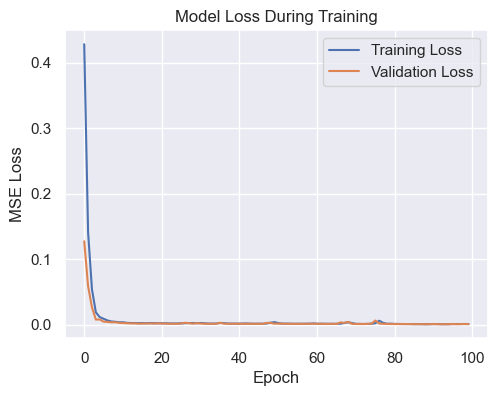

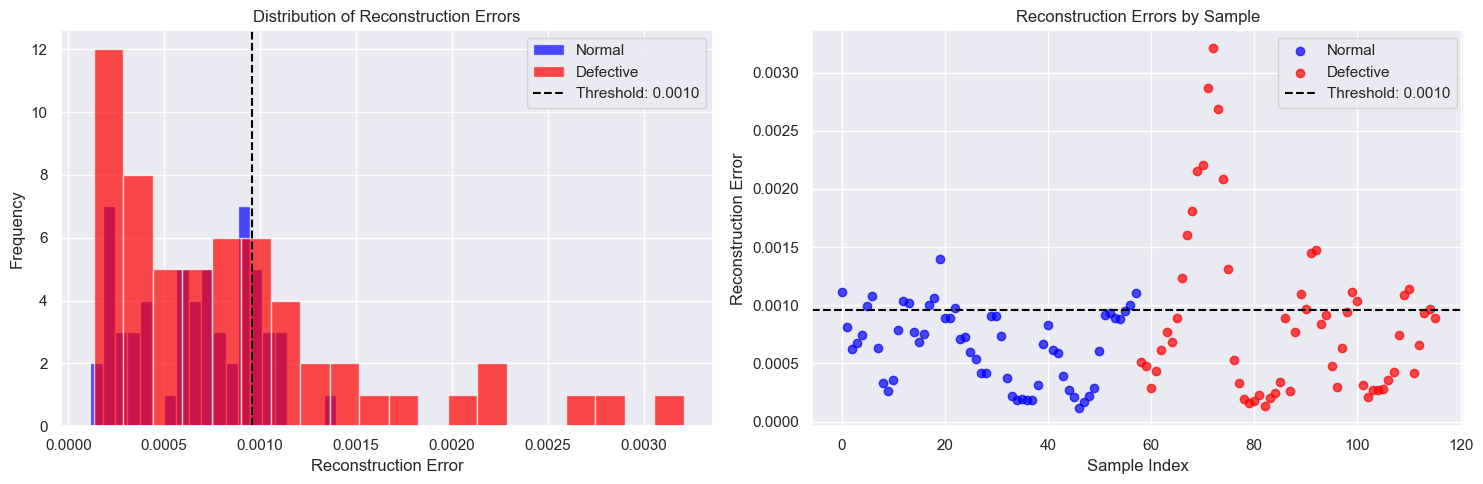


Detailed Error Statistics:
Training reconstruction error - Mean: 0.000594, Std: 0.000600
Validation reconstruction error - Mean: 0.000765, Std: 0.000556

Per-Component Analysis:
Normal components - Mean error: 0.000658
Defective components - Mean error: 0.000871


In [77]:
model, scaler, threshold, results = run_anomaly_detection(df_train, df_validation)

In [28]:
# Let's also create a simple test function to check your data
def check_data_structure(df_train, df_validation):
    """
    Check the structure of your data to ensure it's properly formatted
    """
    print("=" * 50)
    print("DATA STRUCTURE CHECK")
    print("=" * 50)
    
    print(f"df_train shape: {df_train.shape}")
    print(f"df_validation shape: {df_validation.shape}")
    
    print(f"\ndf_train columns: {list(df_train.columns)}")
    print(f"\ndf_validation columns: {list(df_validation.columns)}")
    
    # Check for NaN values
    print(f"\ndf_train NaN values: {df_train.isnull().sum().sum()}")
    print(f"df_validation NaN values: {df_validation.isnull().sum().sum()}")
    
    # Show first few rows
    print(f"\nFirst 3 rows of df_train:")
    print(df_train.head(3))
    
    print(f"\nFirst 3 rows of df_validation:")
    print(df_validation.head(3))
    
    # Extract component info
    train_cols = [col for col in df_train.columns if col != 'momento']
    val_cols = [col for col in df_validation.columns if col != 'momento']
    
    train_components = list(set([col.split('-')[1] for col in train_cols]))
    val_components = list(set([col.split('-')[1] for col in val_cols]))
    
    print(f"\nTraining components found: {len(train_components)}")
    print(f"Training components: {sorted(train_components)}")
    
    print(f"\nValidation components found: {len(val_components)}")
    print(f"Validation components: {sorted(val_components)}")
    
    return train_components, val_components

# Test your data first
print("\n" + "="*50)
print("TESTING YOUR DATA - Run this first:")
print("train_comps, val_comps = check_data_structure(df_train, df_validation)")
print("="*50)


TESTING YOUR DATA - Run this first:
train_comps, val_comps = check_data_structure(df_train, df_validation)


In [29]:
train_comps, val_comps = check_data_structure(df_train, df_validation)

DATA STRUCTURE CHECK
df_train shape: (151, 69)
df_validation shape: (151, 9)

df_train columns: ['momento', '1-0005', '5-0005', '1-0006', '5-0006', '1-0007', '5-0007', '1-0010', '5-0010', '1-0011', '5-0011', '1-0016', '5-0016', '1-0018', '5-0018', '1-0019', '5-0019', '1-0021', '5-0021', '1-0035', '5-0035', '1-0038', '5-0038', '1-0039', '5-0039', '1-0041', '5-0041', '1-0043', '5-0043', '1-0045', '5-0045', '1-0047', '5-0047', '1-0050', '5-0050', '1-0065', '5-0065', '1-0066', '5-0066', '1-0067', '5-0067', '1-0071', '5-0071', '1-0076', '5-0076', '1-0078', '5-0078', '1-0079', '5-0079', '1-0083', '5-0083', '1-0084', '5-0084', '1-0089', '5-0089', '1-0092', '5-0092', '1-0095', '5-0095', '1-0096', '5-0096', '1-0097', '5-0097', '1-0098', '5-0098', '1-0099', '5-0099', '1-0112', '5-0112']

df_validation columns: ['momento', '1-0116', '5-0116', '1-0109', '5-0109', '1-0008', '5-0008', '1-0064', '5-0064']

df_train NaN values: 0
df_validation NaN values: 0

First 3 rows of df_train:
    momento  1-00

In [51]:
from keras_tuner import HyperModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

class LSTMAutoencoderHyperModel(HyperModel):
    def __init__(self, window_size, n_features):
        self.window_size = window_size
        self.n_features = n_features

    def build(self, hp):
        encoding_dim = hp.Choice('encoding_dim', [16, 32, 64, 128])
        learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])
        
        input_layer = Input(shape=(self.window_size, self.n_features))
        encoded = LSTM(encoding_dim, activation='relu')(input_layer)
        decoded = RepeatVector(self.window_size)(encoded)
        decoded = LSTM(encoding_dim, activation='relu', return_sequences=True)(decoded)
        decoded = TimeDistributed(Dense(self.n_features))(decoded)

        model = Model(input_layer, decoded)
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        
        return model


In [59]:
from keras_tuner import HyperModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam



class LSTMAutoencoderHyperModel(HyperModel):
    def __init__(self, window_size, n_features):
        self.window_size = window_size
        self.n_features = n_features

    def build(self, hp):
        encoding_dim = hp.Choice('encoding_dim', [16, 32, 64, 128])
        learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        num_layers = hp.Choice('num_layers', [1, 2])
        activation = hp.Choice('activation', ['relu', 'tanh'])

        input_layer = Input(shape=(self.window_size, self.n_features))
        x = input_layer

        # Encoder
        for _ in range(num_layers):
            x = LSTM(encoding_dim, activation=activation)(x)

        # Bottleneck
        x = RepeatVector(self.window_size)(x)

        # Decoder
        for _ in range(num_layers):
            x = LSTM(encoding_dim, activation=activation, return_sequences=True)(x)

        output_layer = TimeDistributed(Dense(self.n_features))(x)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model



In [60]:
from keras_tuner.tuners import RandomSearch

# Example: assuming you already have df_train and df_validation
window_size = 15  # or whatever you want to test with
step_size = 5

X_train, X_val, component_labels, scaler = prepare_component_data(df_train, df_validation, window_size, step_size)

# Now these will work
window_size = X_train.shape[1]
n_features = X_train.shape[2]



hypermodel = LSTMAutoencoderHyperModel(window_size=window_size, n_features=n_features)

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='lstm_autoencoder'
)


Training components: 34
Validation components: 4
Reloading Tuner from tuning_dir/lstm_autoencoder/tuner0.json


In [61]:
tuner.search(
    X_train, X_train,
    epochs=50,
    batch_size=64,  # Can also be a hyperparameter if you want
    validation_split=0.1,
    shuffle=True,
    verbose=2
)


In [62]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters()[0]

print("Best hyperparameters:")
print(best_hp.values)


Best hyperparameters:
{'encoding_dim': 128, 'learning_rate': 0.001, 'num_layers': 1, 'activation': 'relu'}


/opt/miniconda3/envs/tf310/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
